In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import os
from itertools import product
from functions import (load_parameters, load_generation_data, load_price_data, generate_randomized_generation,
generate_rt_scenarios, plot_generation_data, plot_randomized_generation, plot_scenarios_for_generator, plot_rt_scenarios)

generation_data, I, T = load_generation_data(date_filter="2022-07-18")
S, R, P_RT, K, K0, M1, M2 = load_parameters(I, T, generation_data)
P_DA, P_PN = load_price_data()

✅ 총 3개 파일을 불러왔습니다: 1201.csv, 137.csv, 401.csv
📊 데이터 Shape: I=3, T=24, S=3
✅ 시뮬레이션 초기화 완료: S=3, Randomness='high', M1=640.41, M2=1276.41


/Users/jangseohyun/Documents/workspace/symply/DER/functions.py:96: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  nyc_rt["Hour"] = nyc_rt["Time Stamp"].dt.floor("H")


In [2]:
only = gp.Model("only")
only.setParam("MIPGap", 1e-7)

x = only.addVars(I, T, vtype=GRB.CONTINUOUS, lb=0, name="x")
yp = only.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
ym = only.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
z = only.addVars(I, T+1, S, vtype=GRB.CONTINUOUS, name="z")
zc = only.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z_charge")
zd = only.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z_discharge")
zeta = only.addVars(I, T, S, vtype=GRB.BINARY, name="zeta")
delta = only.addVars(I, T, S, vtype=GRB.BINARY, name="delta")
rho = only.addVars(I, T, S, vtype=GRB.BINARY, name="rho")

only.update()

obj = gp.quicksum(P_DA[t] * x[i, t] for i, t in product(range(I), range(T))) \
    + gp.quicksum(1 / S * (P_RT[t, s] * yp[i, t, s] - P_PN[t] * ym[i, t, s]) for i, t, s in product(range(I), range(T), range(S)))

only.setObjective(obj, GRB.MAXIMIZE)

for i, t, s in product(range(I), range(T), range(S)):
    only.addConstr(R[i, t, s] - x[i, t] == yp[i, t, s] - ym[i, t, s] + zc[i, t, s] - zd[i, t, s])
    only.addConstr(yp[i, t, s] <= R[i, t, s])
    only.addConstr(z[i, t + 1, s] == z[i, t, s] + zc[i, t, s] - zd[i, t, s])
    only.addConstr(zd[i, t, s] <= z[i, t, s])
    only.addConstr(zc[i, t, s] <= K[i] - z[i, t, s])
    only.addConstr(yp[i, t, s] <= M1 * rho[i, t, s])
    only.addConstr(ym[i, t, s] <= M1 * (1 - rho[i, t, s]))
    only.addConstr(ym[i, t, s] <= M1 * delta[i, t, s])
    only.addConstr(zc[i, t, s] <= M1 * (1 - delta[i, t, s]))
    only.addConstr(zc[i, t, s] <= M1 * zeta[i, t, s])
    only.addConstr(zd[i, t, s] <= M1 * (1 - zeta[i, t, s]))
for i, s in product(range(I), range(S)):
    only.addConstr(z[i, 0, s] == K0[i])

only.optimize()

if only.status == GRB.OPTIMAL:
    print(f"Optimal solution found! Objective value: {only.objVal}")
else:
    print("No optimal solution found.")

x_vals = np.array([[x[i, t].X for t in range(T)] for i in range(I)])
yp_vals = np.array([[[yp[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)]) 
ym_vals = np.array([[[ym[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
z_vals  = np.array([[[z[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
zc_vals = np.array([[[zc[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
zd_vals = np.array([[[zd[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])

Set parameter Username
Set parameter LicenseID to value 2611964
Academic license - for non-commercial use only - expires 2026-01-20
Set parameter MIPGap to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  1e-07

Optimize a model with 2385 rows, 1809 columns and 5625 nonzeros
Model fingerprint: 0xf18203eb
Variable types: 1161 continuous, 648 integer (648 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [2e+01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 6e+02]
Found heuristic solution: objective 718952.15099
Presolve removed 1731 rows and 1263 columns
Presolve time: 0.04s
Presolved: 654 rows, 546 columns, 1652 nonzeros
Found heuristic solution: objective 874762.17933
Variable types: 351 continuous, 195 integer (195 binary)

Root relaxation: objective 9.5

In [3]:
da_profit = sum(P_DA[t] * x[i, t].X for i in range(I) for t in range(T))
rt_profit = sum(P_RT[t, s] * yp[i, t, s].X / S for i in range(I) for t in range(T) for s in range(S))
pn_cost   = sum(P_PN[t] * ym[i, t, s].X / S for i in range(I) for t in range(T) for s in range(S))
total_profit = da_profit + rt_profit - pn_cost

print("[DISAGGREGATION MODEL]")
print(f"DA Profit      = {da_profit:.2f}")
print(f"RT Profit      = {rt_profit:.2f}")
print(f"Penalty Cost   = {pn_cost:.2f}")
print(f"Total Profit   = {total_profit:.2f}")

[DISAGGREGATION MODEL]
DA Profit      = 325808.73
RT Profit      = 632891.02
Penalty Cost   = 8414.30
Total Profit   = 950285.45



[ONLY MODEL] Day-Ahead Commitment (sum over DERs):
TOTAL: 2126.14


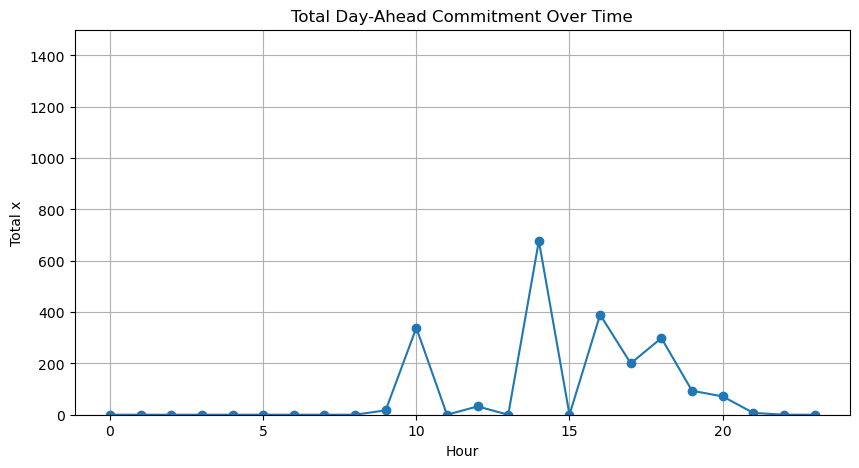

In [4]:
print("\n[ONLY MODEL] Day-Ahead Commitment (sum over DERs):")
total_only_commit = 0
for t in range(T):
    commit_t = sum(x[i, t].X for i in range(I))
    total_only_commit += commit_t
    # print(f"Time {t}: {commit_t:.2f}")
print(f"TOTAL: {total_only_commit:.2f}")

plt.figure(figsize=(10, 5))
plt.plot(range(T), x_vals.sum(axis=0), marker='o')
plt.title("Total Day-Ahead Commitment Over Time")
plt.xlabel("Hour")
plt.ylabel("Total x")
plt.ylim(0,1500)
plt.grid(True)
plt.show()

In [5]:
for t in range(13,15):
    for i in range(I):
        for s in range(0,2):
            R_val  = R[i, t, s]
            x_val  = x_vals[i, t]
            yp_val = yp_vals[i, t, s]
            ym_val = ym_vals[i, t, s]
            zc_val = zc_vals[i, t, s]
            zd_val = zd_vals[i, t, s]

            lhs = R_val - x_val
            rhs = yp_val - ym_val + zc_val - zd_val

            print(f"[i={i}, t={t:02d}, s={s:02d}]  R={R_val:.2f}, x={x_val:.2f}, y⁺={yp_val:.2f}, y⁻={ym_val:.2f}, zᶜ={zc_val:.2f}, zᴰ={zd_val:.2f}")
            # print(f"                 LHS = {lhs:.2f}, RHS = {rhs:.2f}")

[i=0, t=13, s=00]  R=284.25, x=0.00, y⁺=284.25, y⁻=0.00, zᶜ=0.00, zᴰ=0.00
[i=0, t=13, s=01]  R=361.78, x=0.00, y⁺=361.78, y⁻=0.00, zᶜ=0.00, zᴰ=0.00
[i=1, t=13, s=00]  R=112.40, x=0.00, y⁺=112.40, y⁻=0.00, zᶜ=0.00, zᴰ=0.00
[i=1, t=13, s=01]  R=453.50, x=0.00, y⁺=453.50, y⁻=0.00, zᶜ=0.00, zᴰ=0.00
[i=2, t=13, s=00]  R=131.93, x=0.00, y⁺=131.93, y⁻=0.00, zᶜ=0.00, zᴰ=0.00
[i=2, t=13, s=01]  R=265.41, x=0.00, y⁺=265.41, y⁻=0.00, zᶜ=0.00, zᴰ=0.00
[i=0, t=14, s=00]  R=129.09, x=96.65, y⁺=0.00, y⁻=0.00, zᶜ=32.44, zᴰ=0.00
[i=0, t=14, s=01]  R=291.11, x=96.65, y⁺=102.36, y⁻=0.00, zᶜ=92.10, zᴰ=0.00
[i=1, t=14, s=00]  R=85.11, x=291.63, y⁺=0.00, y⁻=106.52, zᶜ=0.00, zᴰ=100.00
[i=1, t=14, s=01]  R=392.33, x=291.63, y⁺=0.71, y⁻=0.00, zᶜ=100.00, zᴰ=0.00
[i=2, t=14, s=00]  R=189.28, x=289.28, y⁺=0.00, y⁻=0.00, zᶜ=0.00, zᴰ=100.00
[i=2, t=14, s=01]  R=454.40, x=289.28, y⁺=65.12, y⁻=0.00, zᶜ=100.00, zᴰ=0.00


In [6]:
i=0
s=4
zc_single = zc_vals[i, :, s]  
zd_single = zd_vals[i, :, s]
z_single = z_vals[i, :, s]
hours = np.arange(len(zc_single))

plt.figure(figsize=(12, 5))
# plt.step(hours, zc_single, where='post', label=f"Charge (DER {i}, Scen {s})", color = 'green', linestyle = "--", linewidth = 1.5)
# plt.step(hours, zd_single, where='post', label=f"Discharge (DER {i}, Scen {s})", linestyle = "--", color = 'red')
plt.step(hours, z_single, where='post', label=f"SoC (DER {i}, Scen {s})", color='#00821E', linewidth=2)
plt.title(f"[Only] Battery Charging/Discharging (DER {i}, Scenario {s})")
plt.xlabel("Hour")
plt.ylabel("Energy (kWh)")
plt.xticks(hours)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

IndexError: index 4 is out of bounds for axis 2 with size 3